In [11]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib
from ilqr.envs import PointMass
import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

# utility function

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def iLQR(env, iterations=100, 
         reg = 1,                  # initial regularization
         reg_lims = (1e-6, 1e10),  # limtis on regularization
         dreg = 2,                 # reg is multiplied or divided by dreg
         dreg_factor = 1.6         # dreg is multiplied or diveded by dreg_factor):
        ):        

    """
    todo:
    - line search for alpha parameter
    - add convergence check
    """

    # initial trajectory
    actions = [(0,0) for i in range(env.max_steps)]
    states, costs, costs_derivs = env.rollout(actions)
    state_derivs = [env.state_derivs(s,a) for s,a in zip(states, actions)]
    V_x  = costs_derivs[-1]['l_x']
    V_xx = costs_derivs[-1]['l_xx']
    history = dict(cost=[], reg=[])

    for i in tqdm(range(iterations)):
        k, K = [], []

        # backward pass
        # (computed new control rules k and K)
        for t in range(env.max_steps-1, -1, -1):
            l, f = costs_derivs[t], state_derivs[t]

            Q_x  = l['l_x']  + f['f_x'].T @ V_x
            Q_u  = l['l_u']  + f['f_u'].T @ V_x
            Q_xx = l['l_xx'] + f['f_x'].T @ V_xx @ f['f_x']
            Q_uu = l['l_uu'] + f['f_u'].T @ V_xx @ f['f_u']
            Q_ux = l['l_ux'] + f['f_u'].T @ V_xx @ f['f_x']

            # compute Q_uu inverse
            evals, evecs = np.linalg.eig(Q_uu)
            evals[evals<0] = 0.0
            evals += reg
            Q_uu_inv = evecs @ np.diag(1/evals) @ evecs.T

            # control law
            k.append(-Q_uu_inv @ Q_u)
            K.append(-Q_uu_inv @ Q_ux)

            # update V
            V_x  = Q_x  + K[-1].T @ Q_uu @ k[-1] + K[-1].T @ Q_u  + Q_ux.T @ k[-1]
            V_xx = Q_xx + K[-1].T @ Q_uu @ K[-1] + K[-1].T @ Q_ux + Q_ux.T @ K[-1]
        k.reverse()
        K.reverse()

        # forward pass
        # (compute new trajectory with new control law)
        states_new, costs_new, actions_new = [], [], []
        states_new.append(env.reset(reset_target=False))

        for t in range(env.max_steps):
            action_new = actions[t] + k[t] + K[t] @ (states_new[-1] - states[t])
            actions_new.append(action_new)
            costs_new.append(env.cost(states_new[-1], actions_new[-1])[0])
            states_new.append(env.step(actions_new[-1]))
        history['cost'].append(sum(costs_new))

        # regularization update
        delta_cost = sum(costs_new) - sum(costs)
        if delta_cost>0:  # increase regularization
            dreg = max(dreg_factor, dreg_factor*dreg)
            reg = np.clip(reg*dreg, reg_lims[0], reg_lims[1])

        else:             # decrease regularization
            dreg = min(1/dreg_factor, dreg/dreg_factor)
            reg *= dreg * (reg < reg_lims[0])

            actions = actions_new
            states = states_new
            costs = costs_new
        history['reg'].append(reg)
    
    return actions, history

100%|██████████| 100/100 [00:01<00:00, 50.88it/s]


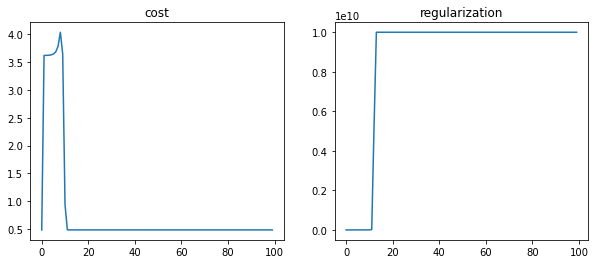

In [27]:
env = PointMass()
actions, history = iLQR(env)
ax = plt.subplots(1,2, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');

In [28]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))